# Project 2 Data Wrangling and EAD

Data in the real world is messy. Dealing with messy data sets is painful and burns through time which could be spent analysing the data itself.

This dataset contains historic work order text data for different divisions.  The data is generated using queries in a relational database and exported as csv files.  Some data are scrambled.  

In [831]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import re
import ftfy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [832]:
def cleanse_str(string): 
    string = ftfy.fix_text(string) # fix text encoding issues
    string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
    string = string.lower() #make lower case
    chars_to_remove = ["#", "@", ")","(",".","|","[","]","{","}","'"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    string = re.sub(rx, '', string) #remove the list of chars defined above
    string = string.replace('&', 'and')
    string = string.replace(',', ' ')
    #string = string.replace('unknown', ' ')
    string = string.replace('-', ' ')
    string = string.replace('+', ' and ')
    #string = string.title() # normalise case - capital at start of each word
    string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single space
    string = ' '+ string +' ' # pad names for ngrams...
    string = re.sub(r'[,-./]|\sBD',r'', string)

    return string

In [833]:
# load data
file_path = 'LocalPath'

df4_g=pd.read_csv(file_path + 'p_addr_list.csv',encoding='ISO-8859-1')

df_match = pd.read_csv(file_path + 'addr_match.csv')
df_exception = pd.read_csv(file_path + 'addr_exception.csv')

df_raw_sum = pd.read_csv(file_path + 'addr_raw_sum.csv')
df_match_1_n = pd.read_csv(file_path + 'addr_match_1_n.csv')

In [834]:
df_master = df=pd.read_csv(file_path + 'addr_master.csv')

In [835]:
#df=pd.read_csv(file_path + 'Sample_Data_WOAddr_messy.csv')

In [836]:
#df['addr1'].fillna(df['city1'], inplace=True)
#df['addr_cln']= df['addr1'].apply(cleanse_str)#.str.lower()
#df['addr_cln'].str.upper()

In [837]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505767 entries, 0 to 505766
Data columns (total 3 columns):
P_DIV_CD    505767 non-null object
P_ADDR      505761 non-null object
P_CITY      505767 non-null object
dtypes: object(3)
memory usage: 11.6+ MB


In [838]:
df_master.dropna(inplace=True)

In [839]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505761 entries, 0 to 505766
Data columns (total 3 columns):
P_DIV_CD    505761 non-null object
P_ADDR      505761 non-null object
P_CITY      505761 non-null object
dtypes: object(3)
memory usage: 15.4+ MB


In [840]:
df_exception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530437 entries, 0 to 530436
Data columns (total 6 columns):
DATAID         530437 non-null object
M_TXT          530437 non-null object
M_DIV_CD       530437 non-null object
M_ADDR         526190 non-null object
M_CITY         530320 non-null object
M_ADDR_TYPE    530401 non-null object
dtypes: object(6)
memory usage: 24.3+ MB


In [841]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
dtypes: int64(2), object(8)
memory usage: 2.3+ MB


In [842]:
df_exception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530437 entries, 0 to 530436
Data columns (total 6 columns):
DATAID         530437 non-null object
M_TXT          530437 non-null object
M_DIV_CD       530437 non-null object
M_ADDR         526190 non-null object
M_CITY         530320 non-null object
M_ADDR_TYPE    530401 non-null object
dtypes: object(6)
memory usage: 24.3+ MB


In [843]:
# handle NULL fields
df_exception['M_ADDR'].fillna(df_exception['M_TXT'], inplace=True)
df_exception['M_ADDR_TYPE'].fillna('Unknown', inplace=True)
df_exception['M_CITY'].fillna('Unknown', inplace=True)

In [844]:
df_exception.M_ADDR_TYPE.unique()

array(['SIMPLE', 'LOT', 'ROUTE', 'RANGE', 'NOTDEFINED', 'BLOCK', 'BLANK',
       'MULTI', 'Unknown'], dtype=object)

In [845]:
# cleanse text
print('Start text cleansing ...')
time1 = time.time()

df_match['M_ADDR_c'] = df_match['M_ADDR'].apply(cleanse_str)
df_match['P_ADDR_c'] = df_match['P_ADDR'].apply(cleanse_str)
df_match['M_TXT_c'] = df_match['M_TXT'].apply(cleanse_str)
df_exception['M_ADDR_c'] = df_exception['M_ADDR'].apply(cleanse_str)
df_exception['M_TXT_c'] = df_exception['M_TXT'].apply(cleanse_str)

df_match['M_CITY'] = df_match['M_CITY'].str.lower()
df_match['P_CITY'] = df_match['P_CITY'].str.lower()
df_exception['M_CITY'] = df_exception['M_CITY'].str.lower()

t = time.time() - t1
print("SELFTIMED:", t)

Start text cleansing ...
SELFTIMED: 254240.8039753437


In [846]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
M_ADDR_c       30000 non-null object
P_ADDR_c       30000 non-null object
M_TXT_c        30000 non-null object
dtypes: int64(2), object(11)
memory usage: 3.0+ MB


In [847]:
df_exception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530437 entries, 0 to 530436
Data columns (total 8 columns):
DATAID         530437 non-null object
M_TXT          530437 non-null object
M_DIV_CD       530437 non-null object
M_ADDR         530437 non-null object
M_CITY         530437 non-null object
M_ADDR_TYPE    530437 non-null object
M_ADDR_c       530437 non-null object
M_TXT_c        530437 non-null object
dtypes: object(8)
memory usage: 32.4+ MB


In [849]:
df_exception_s= df_exception[df_exception.M_ADDR_TYPE=='SIMPLE']

In [850]:
df_exception_s[df_exception.M_DIV_CD=='d6'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12166 entries, 8649 to 530435
Data columns (total 8 columns):
DATAID         12166 non-null object
M_TXT          12166 non-null object
M_DIV_CD       12166 non-null object
M_ADDR         12166 non-null object
M_CITY         12166 non-null object
M_ADDR_TYPE    12166 non-null object
M_ADDR_c       12166 non-null object
M_TXT_c        12166 non-null object
dtypes: object(8)
memory usage: 855.4+ KB


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [853]:
df_raw_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080574 entries, 0 to 1080573
Data columns (total 4 columns):
DATAID         1080574 non-null int64
M_DIV_CD       1080574 non-null object
M_ADDR_TYPE    1080574 non-null object
FOUND_MATCH    1080574 non-null object
dtypes: int64(1), object(3)
memory usage: 33.0+ MB


In [854]:
df_raw_sum.head()

,DATAID,M_DIV_CD,M_ADDR_TYPE,FOUND_MATCH
0,35137,d2,SIMPLE,N
1,35138,d2,SIMPLE,N
2,35139,d2,SIMPLE,N
3,35140,d2,RANGE,N
4,35141,d2,RANGE,N


## EDA

Next, we will explore the data set.  Used the third party address tool to match the legacy address with address master data set.  We will analyze the matching results as well

In [855]:
def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            # Vertical alignment
            va = 'top'

        label = "{:}".format(y_value)  # Use :.1f if wanting decimals.

        # Create annotation
        ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va=va)

In [856]:
# exam matched - random sampled
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
M_ADDR_c       30000 non-null object
P_ADDR_c       30000 non-null object
M_TXT_c        30000 non-null object
dtypes: int64(2), object(11)
memory usage: 3.0+ MB


In [857]:
df_raw_sum.head()

,DATAID,M_DIV_CD,M_ADDR_TYPE,FOUND_MATCH
0,35137,d2,SIMPLE,N
1,35138,d2,SIMPLE,N
2,35139,d2,SIMPLE,N
3,35140,d2,RANGE,N
4,35141,d2,RANGE,N


In [858]:
df_raw_sum.M_DIV_CD.unique()

array(['d2', 'd3', 'd6', 'd1', 'd7', 'd5', 'd4'], dtype=object)

In [859]:
df_raw_sum[df_raw_sum.FOUND_MATCH=='Y'].head()

,DATAID,M_DIV_CD,M_ADDR_TYPE,FOUND_MATCH
11,35148,d2,SIMPLE,Y
63,35203,d2,SIMPLE,Y
64,35204,d2,SIMPLE,Y
65,35205,d2,SIMPLE,Y
66,35206,d2,SIMPLE,Y


In [860]:
stat = df_raw_sum.groupby('M_DIV_CD').DATAID.count()
df_temp = pd.DataFrame({'DIV_CD':stat.index, 'Raw_Total':stat.values})

stat2 = df_raw_sum[df_raw_sum.FOUND_MATCH=='Y'].groupby('M_DIV_CD').DATAID.count()
df_temp2 = pd.DataFrame({'DIV_CD':stat2.index, 'Matched_Total':stat2.values})

df_stat_by_div = pd.merge(df_temp, df_temp2, on='DIV_CD', how='outer')

In [861]:
stat2

M_DIV_CD
d1     23098
d2    341756
d3     28863
d4     83720
d5     26632
d6     22205
d7     23881
Name: DATAID, dtype: int64

In [862]:
df_stat_by_div

,DIV_CD,Raw_Total,Matched_Total
0,d1,81691,23098
1,d2,622397,341756
2,d3,63682,28863
3,d4,141892,83720
4,d5,49242,26632
5,d6,43782,22205
6,d7,77888,23881


In [863]:
stat = df_raw_sum.groupby('M_ADDR_TYPE').DATAID.count()
df_temp = pd.DataFrame({'TYPE':stat.index, 'Raw_Total':stat.values})

stat2 = df_raw_sum[df_raw_sum.FOUND_MATCH=='Y'].groupby('M_ADDR_TYPE').DATAID.count()
df_temp2 = pd.DataFrame({'TYPE':stat2.index, 'Matched_Total':stat2.values})

df_stat_by_type = pd.merge(df_temp, df_temp2, on='TYPE', how='outer')

In [864]:
df_stat_by_type

,TYPE,Raw_Total,Matched_Total
0,BLANK,69985,6.0
1,BLOCK,2581,NaN
2,LOT,21160,43.0
3,MULTI,3243,1863.0
4,NOTDEFINED,18089,3757.0
5,RANGE,22646,9968.0
6,ROUTE,8995,NaN
7,SIMPLE,933875,534518.0


In [865]:
df_stat_by_type.fillna(0, inplace=True)

In [866]:
df_stat_by_type

,TYPE,Raw_Total,Matched_Total
0,BLANK,69985,6.0
1,BLOCK,2581,0.0
2,LOT,21160,43.0
3,MULTI,3243,1863.0
4,NOTDEFINED,18089,3757.0
5,RANGE,22646,9968.0
6,ROUTE,8995,0.0
7,SIMPLE,933875,534518.0


In [867]:
print (df_raw_sum.groupby(['M_DIV_CD','FOUND_MATCH']).size().unstack(fill_value=0))

FOUND_MATCH       N       Y
M_DIV_CD                   
d1            58593   23098
d2           280641  341756
d3            34819   28863
d4            58172   83720
d5            22610   26632
d6            21577   22205
d7            54007   23881


In [868]:
print (df_raw_sum.groupby(['M_ADDR_TYPE','FOUND_MATCH']).size().unstack(fill_value=0))

FOUND_MATCH       N       Y
M_ADDR_TYPE                
BLANK         69979       6
BLOCK          2581       0
LOT           21117      43
MULTI          1380    1863
NOTDEFINED    14332    3757
RANGE         12678    9968
ROUTE          8995       0
SIMPLE       399357  534518


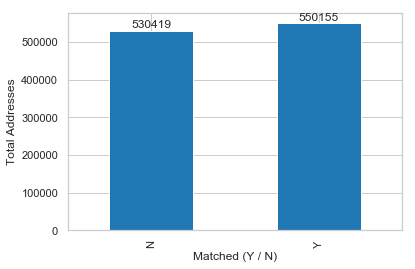

In [869]:
plt.figure(figsize=(6,4))

result_plot = df_raw_sum.groupby(['FOUND_MATCH']).DATAID.count().plot.bar()
plt.xlabel('Matched (Y / N)')
plt.ylabel('Total Addresses')
add_value_labels(result_plot, 1)
plt.show()

### Total 550155 found match but still have 530419 not found the match 

<Figure size 576x432 with 0 Axes>

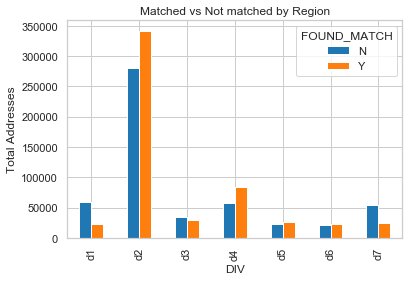

In [870]:
plt.figure(figsize=(8,6))

rsd_plot = df_raw_sum.groupby(['M_DIV_CD','FOUND_MATCH']).size().unstack(fill_value=0).plot.bar()
plt.xlabel('DIV')
plt.ylabel('Total Addresses')
plt.title('Matched vs Not matched by Region')
#add_value_labels(rsd_plot, 1)
plt.show()

### The above plot shows the matched vs not matched within each region 

<Figure size 576x432 with 0 Axes>

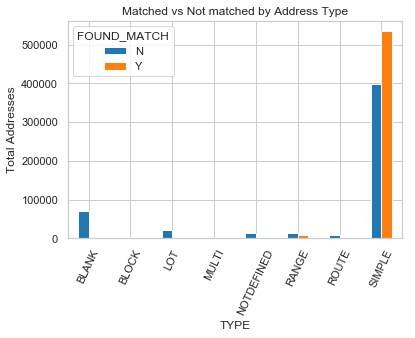

In [871]:
plt.figure(figsize=(8,6))
rst_plot = df_raw_sum.groupby(['M_ADDR_TYPE','FOUND_MATCH']).size().unstack(fill_value=0).plot.bar()
plt.xlabel('TYPE')
plt.ylabel('Total Addresses')
plt.title('Matched vs Not matched by Address Type')
#add_value_labels(rst_plot, 1)
plt.xticks(rotation=65) 
plt.show()

### The above plot shows the matched vs not matched by address type.  Majority addresses have SIMPLE type 

In [872]:
# the maximum addresses one address mapped to the master addresses.  Use this to determine the top_N
df_match_1_n.CNT.max()

32

####  One address was possibly matched to multiple master addresses (i.e., apartment complex).  Use this to determine the top_N

## Exploring fuzzywuzzy fuctions

In [873]:
str1='This is a test.  Installed service pipe @ 9029 A Hwy 119 S on [2/10/2017] '
str2='9029 A HWY 119 S'
str3='9029 Highway 119'

In [874]:
def exporing_fuzzywuzzy_func (str1, str2, str3):
    str1_c = cleanse_str(str1)
    str2_c = cleanse_str(str2)
    str3_c = cleanse_str(str3)
    print('str1_c: ', str1_c)
    print('str2_c: ', str2_c)
    print('str3_c: ', str3_c)
    print()
    print('Compare free text with std addr ... start here ...')

    r1 = fuzz.ratio (str1, str3)
    r1c = fuzz.ratio (str1_c, str3_c)

    pr1 = fuzz.partial_ratio(str1, str3)
    pr1c = fuzz.partial_ratio(str1_c, str3_c)

    tsr1 = fuzz.token_sort_ratio(str1, str3) 
    tsr1c = fuzz.token_sort_ratio(str1_c, str3_c) 

    tstr1 = fuzz.token_set_ratio(str1, str3)
    tstr1c = fuzz.token_set_ratio(str1_c, str3_c)

    print('Raw - ratio :', r1)
    print('Cleansed - Function ratio :', r1c)
    print()
    print('Raw - partial_ratio :', pr1)
    print('Cleansed - partial_ratio :', pr1c)
    print()
    print('Raw - token_sort_ratio :', tsr1)
    print('Cleansed - token_sort_ratio :', tsr1c)
    print()
    print('Raw - token_set_ratio :', tstr1)
    print('Cleansed - token_set_ratio :', tstr1c)
    print()

    print()
    print('Compare addr with std addr...start here...')
    r2 = fuzz.ratio (str2, str3)
    r2c = fuzz.ratio (str2_c, str3_c)

    pr2 = fuzz.partial_ratio(str2, str3)
    pr2c = fuzz.partial_ratio(str2_c, str3_c)

    tsr2 = fuzz.token_sort_ratio(str2, str3) 
    tsr2c = fuzz.token_sort_ratio(str2_c, str3_c) 

    tstr2 = fuzz.token_set_ratio(str2, str3)
    tstr2c = fuzz.token_set_ratio(str2_c, str3_c)

    print('Raw - ratio :', r2)
    print('Cleansed - Function ratio :', r2c)
    print()
    print('Raw - partial_ratio :', pr2)
    print('Cleansed - partial_ratio :', pr2c)
    print()
    print('Raw - token_sort_ratio :', tsr2)
    print('Cleansed - token_sort_ratio :', tsr2c)
    print()
    print('Raw - token_set_ratio :', tstr2)
    print('Cleansed - token_set_ratio :', tstr2c)
    print()

In [875]:
exporing_fuzzywuzzy_func (str1, str2, str3)

str1_c:   this is a test installed service pipe 9029 a hwy 119 s on 2102017 
str2_c:   9029 a hwy 119 s 
str3_c:   9029 highway 119 

Compare free text with std addr ... start here ...
Raw - ratio : 27
Cleansed - Function ratio : 33

Raw - partial_ratio : 75
Cleansed - partial_ratio : 78

Raw - token_sort_ratio : 29
Cleansed - token_sort_ratio : 30

Raw - token_set_ratio : 67
Cleansed - token_set_ratio : 67


Compare addr with std addr...start here...
Raw - ratio : 62
Cleansed - Function ratio : 78

Raw - partial_ratio : 62
Cleansed - partial_ratio : 78

Raw - token_sort_ratio : 75
Cleansed - token_sort_ratio : 75

Raw - token_set_ratio : 75
Cleansed - token_set_ratio : 75



## Fuzzywuzzy functions EDA
Next, will apply these four Fuzzywuzzy fuctions to the sampled data of matched addresses using the third-party address tool.  The confidence level of matching is about 94%.  Then will compare the results and choos the function works best for this data set.

In [876]:
def get_partial_ratio1(row):
    string1 = row['M_ADDR_c']
    string2 = row['P_ADDR_c']
    return fuzz.partial_ratio(string1, string2)

def get_partial_ratio2(row):
    string1 = row['M_TXT_c']
    string2 = row['P_ADDR_c']
    return fuzz.partial_ratio(string1, string2)
'''
df_match['pr1']=df_match.apply(get_partial_ratio1, axis=1)
df_match['pr2']=df_match.apply(get_partial_ratio2, axis=1)
'''

"\ndf_match['pr1']=df_match.apply(get_partial_ratio1, axis=1)\ndf_match['pr2']=df_match.apply(get_partial_ratio2, axis=1)\n"

In [877]:
def get_token_set_ratio1(row):
    string1 = row['M_ADDR_c']
    string2 = row['P_ADDR_c']
    return fuzz.token_set_ratio(string1, string2)

def get_token_set_ratio2(row):
    string1 = row['M_TXT_c']
    string2 = row['P_ADDR_c']
    return fuzz.token_set_ratio(string1, string2)
'''
df_match['tstr1']=df_match.apply(get_token_set_ratio1, axis=1)
df_match['tstr2']=df_match.apply(get_token_set_ratio2, axis=1)
'''

"\ndf_match['tstr1']=df_match.apply(get_token_set_ratio1, axis=1)\ndf_match['tstr2']=df_match.apply(get_token_set_ratio2, axis=1)\n"

In [878]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
M_ADDR_c       30000 non-null object
P_ADDR_c       30000 non-null object
M_TXT_c        30000 non-null object
dtypes: int64(2), object(11)
memory usage: 3.0+ MB


In [879]:
df_match['r1'] = df_match.apply(lambda row: fuzz.ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)
df_match['pr1'] = df_match.apply(lambda row: fuzz.partial_ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)
df_match['tsr1'] = df_match.apply(lambda row: fuzz.token_sort_ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)
df_match['tstr1'] = df_match.apply(lambda row: fuzz.token_set_ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)

In [880]:
df_match['r2'] = df_match.apply(lambda row: fuzz.ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
df_match['pr2'] = df_match.apply(lambda row: fuzz.partial_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
df_match['tsr2'] = df_match.apply(lambda row: fuzz.token_sort_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
df_match['tstr2'] = df_match.apply(lambda row: fuzz.token_set_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)

In [881]:
data_to_display=['M_DIV_CD','M_ADDR_TYPE','pr1','pr1','tsr1','tstr1','pr2','pr2','tsr2','tstr2']
df_match[df_match.pr1<95][data_to_display].head()

,M_DIV_CD,M_ADDR_TYPE,pr1,pr1,tsr1,tstr1,pr2,pr2,tsr2,tstr2
7,d2,SIMPLE,84,84,86,90,84,84,71,90
16,d2,RANGE,93,93,86,100,93,93,69,100
17,d2,SIMPLE,94,94,97,97,94,94,80,80
21,d2,SIMPLE,94,94,97,97,94,94,78,78
24,d2,SIMPLE,88,88,88,88,80,80,72,76


### Calculate percentage of matching with ratio above 90% 

In [882]:
r1_match_pct = len(df_match[df_match.r1 > 90]) / len(df_match)
pr1_match_pct = len(df_match[df_match.pr1 > 90]) / len(df_match)
tsr1_match_pct = len(df_match[df_match.tsr1 > 90]) / len(df_match)
tstr1_match_pct = len(df_match[df_match.tstr1 > 90]) / len(df_match)
print('r1 match (%>90) = ', r1_match_pct)
print('pr1 match (%>90) = ', pr1_match_pct)
print('tsr1 match (%>90) = ', tsr1_match_pct)
print('tstr1 match (%>90) = ', tstr1_match_pct)
print()
r2_match_pct = len(df_match[df_match.r2 > 90]) / len(df_match)
pr2_match_pct = len(df_match[df_match.pr2 > 90]) / len(df_match)
tsr2_match_pct = len(df_match[df_match.tsr2 > 90]) / len(df_match)
tstr2_match_pct = len(df_match[df_match.tstr2 > 90]) / len(df_match)
print('r2 match (%>90) = ', r2_match_pct)
print('pr2 match (%>90) = ', pr2_match_pct)
print('tsr2 match (%>90) = ', tsr2_match_pct)
print('tstr2 match (%>90) = ', tstr2_match_pct)

r1 match (%>90) =  0.8581
pr1 match (%>90) =  0.8755
tsr1 match (%>90) =  0.8383666666666667
tstr1 match (%>90) =  0.908

r2 match (%>90) =  0.0125
pr2 match (%>90) =  0.8255
tsr2 match (%>90) =  0.011733333333333333
tstr2 match (%>90) =  0.7811666666666667


#### Compare address to address, function token_set_ratio got the highest match % (with ratio > 90).  If use the free text (which contains the address) to find the match with address, then partial_ratio perfoms best with 82% with raio>90

In [883]:
r1_mean = df_match['r1'].mean()
pr1_mean = df_match['pr1'].mean()
tsr1_mean = df_match['tsr1'].mean()
tstr1_mean = df_match['tstr1'].mean()
print('r1 mean (%) = ', r1_mean)
print('pr1 mean (%) = ', pr1_mean)
print('tsr1 mean (%) = ', tsr1_mean)
print('tstr1 mean (%) = ', tstr1_mean)
print()
r2_mean = df_match['r2'].mean()
pr2_mean = df_match['pr2'].mean()
tsr2_mean = df_match['tsr2'].mean()
tstr2_mean = df_match['tstr2'].mean()
print('r2 mean (%) = ', r2_mean)
print('pr2 mean (%) = ', pr2_mean)
print('tsr2 mean (%) = ', tsr2_mean)
print('tstr2 mean (%) = ', tstr2_mean)
print()

r1 mean (%) =  96.6229
pr1 mean (%) =  96.90603333333334
tsr1 mean (%) =  96.0952
tstr1 mean (%) =  97.72556666666667

r2 mean (%) =  74.98543333333333
pr2 mean (%) =  95.9572
tsr2 mean (%) =  72.25533333333334
tstr2 mean (%) =  94.7659



### Exam ratio < 90% 

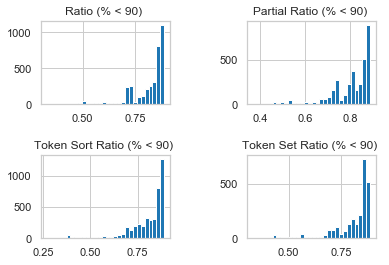

In [884]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)

#ax=fig.add_subplot(2,2,1)
plt.subplot(2,2,1)
_=plt.hist(df_match[df_match.r1< 90].r1/100, bins=30)
plt.title('Ratio (% < 90) ')

plt.subplot(2,2,2)
_=plt.hist(df_match[df_match.pr1< 90].pr1/100, bins=30)
plt.title('Partial Ratio (% < 90) ')
plt.subplot(2,2,3)
_=plt.hist(df_match[df_match.tsr1< 90].tsr1/100, bins=30)
plt.title('Token Sort Ratio (% < 90) ')
plt.subplot(2,2,4)
_=plt.hist(df_match[df_match.tstr1< 90].tstr1/100, bins=30)
plt.title('Token Set Ratio (% < 90) ')
plt.show()

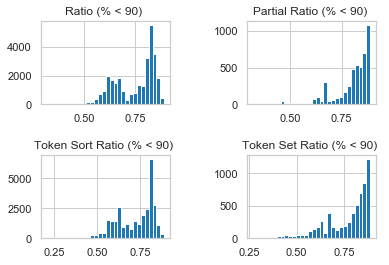

In [885]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)

#ax=fig.add_subplot(2,2,1)
plt.subplot(2,2,1)
_=plt.hist(df_match[df_match.r2< 90].r2/100, bins=30)
plt.title('Ratio (% < 90) ')

plt.subplot(2,2,2)
_=plt.hist(df_match[df_match.pr2< 90].pr2/100, bins=30)
plt.title('Partial Ratio (% < 90) ')
plt.subplot(2,2,3)
_=plt.hist(df_match[df_match.tsr2< 90].tsr2/100, bins=30)
plt.title('Token Sort Ratio (% < 90) ')
plt.subplot(2,2,4)
_=plt.hist(df_match[df_match.tstr2< 90].tstr2/100, bins=30)
plt.title('Token Set Ratio (% < 90) ')
plt.show()

[Text(0, 0, 'Ratio'),
 Text(0, 0, 'Partial Ratio'),
 Text(0, 0, 'Token Sort Ratio'),
 Text(0, 0, 'Token Set Ratio')]

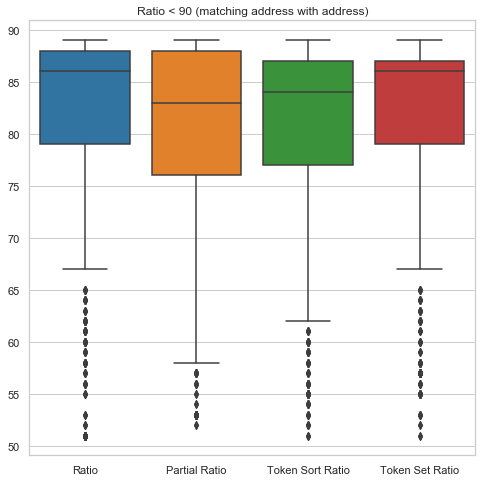

In [889]:
d1=df_match[(df_match.r1>50) & (df_match.r1<90)].r1
d2=df_match[(df_match.pr1>50) & (df_match.pr1<90)].pr1
d3=df_match[(df_match.tsr1>50) & (df_match.tsr1<90)].tsr1
d4=df_match[(df_match.tstr1>50) & (df_match.tstr1<90)].tstr1

data_to_plot = [d1, d2, d3, d4]
xticklables = ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio']

fig = plt.figure(1, figsize=(8, 8))
plt.title('Ratio < 90 (matching address with address)') 
ax = sns.boxplot(data = data_to_plot)
ax.set_xticklabels(xticklables)

### From the above box plat, we can see that for ratio < 90%, the function token_set_ratio has the highest median matching ratio than the other functions 

[Text(0, 0, 'Ratio'),
 Text(0, 0, 'Partial Ratio'),
 Text(0, 0, 'Token Sort Ratio'),
 Text(0, 0, 'Token Set Ratio')]

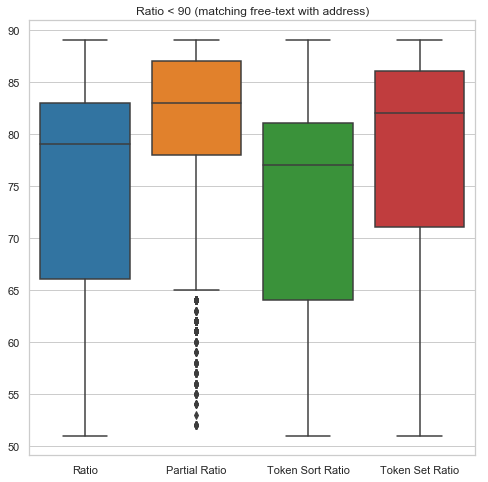

In [890]:
d1=df_match[(df_match.r2>50) & (df_match.r2<90)].r2
d2=df_match[(df_match.pr2>50) & (df_match.pr2<90)].pr2
d3=df_match[(df_match.tsr2>50) & (df_match.tsr2<90)].tsr2
d4=df_match[(df_match.tstr2>50) & (df_match.tstr2<90)].tstr2

data_to_plot = [d1, d2, d3, d4]
xticklables = ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio']

fig = plt.figure(1, figsize=(8, 8))
plt.title('Ratio < 90 (matching free-text with address)') 
ax = sns.boxplot(data = data_to_plot)
ax.set_xticklabels(xticklables)

### From the above box plat, we can see that for ratio < 90%, the function partial_ratio has the highest median matching ratio than the other functions, and token_set_ratio ranks the second